<a href="https://colab.research.google.com/github/DazhiZhong/Pixray_Notebooks/blob/main/Pixray_Loss_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loss Demo

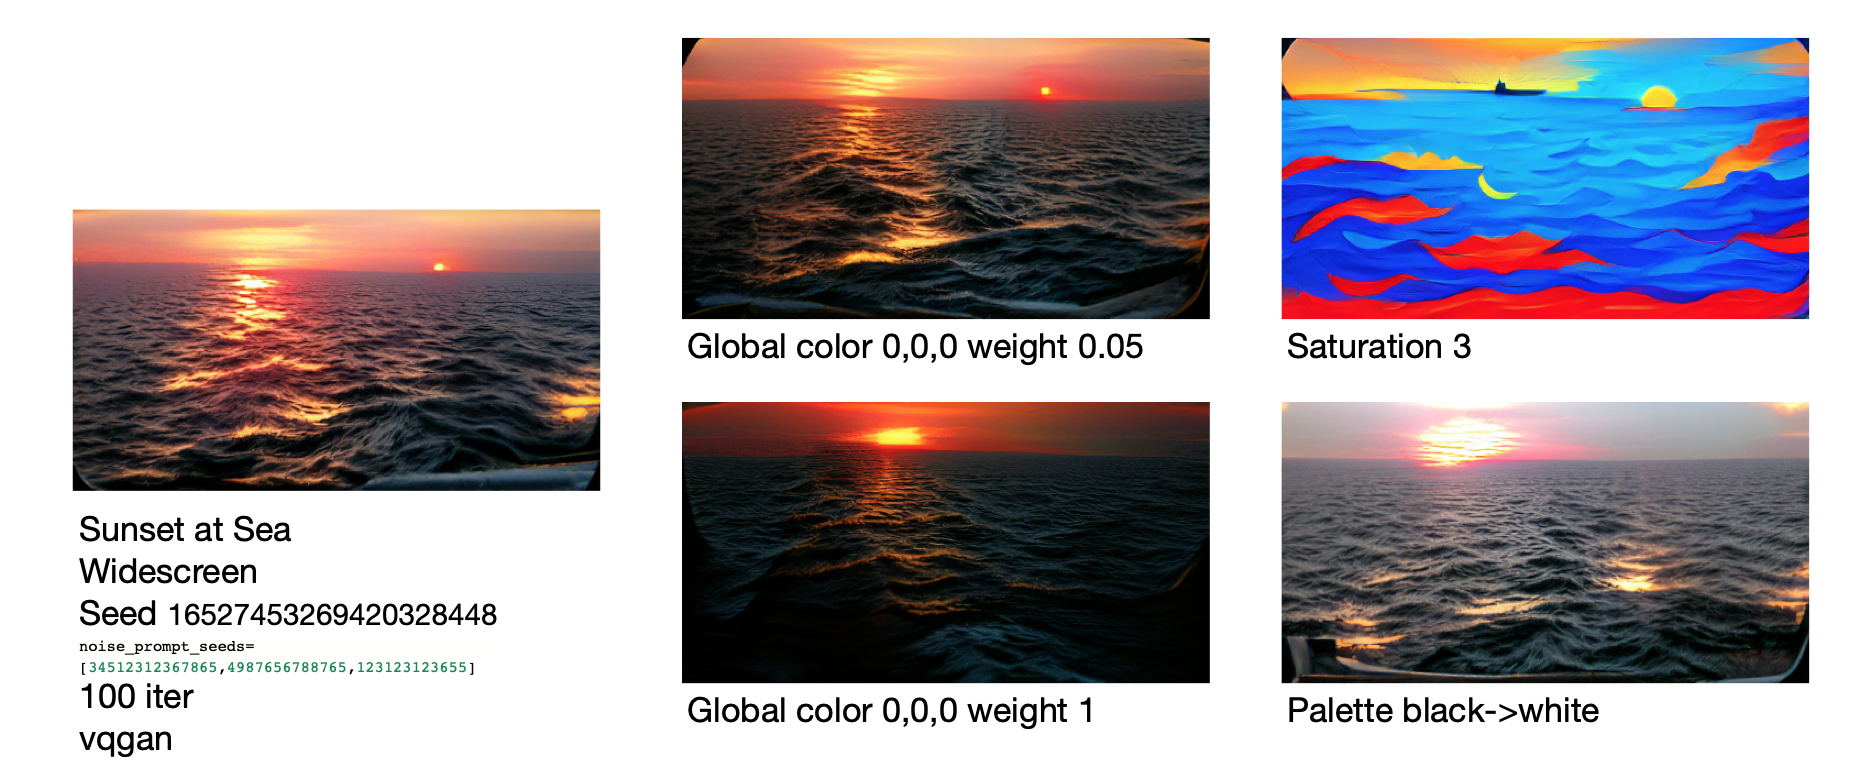

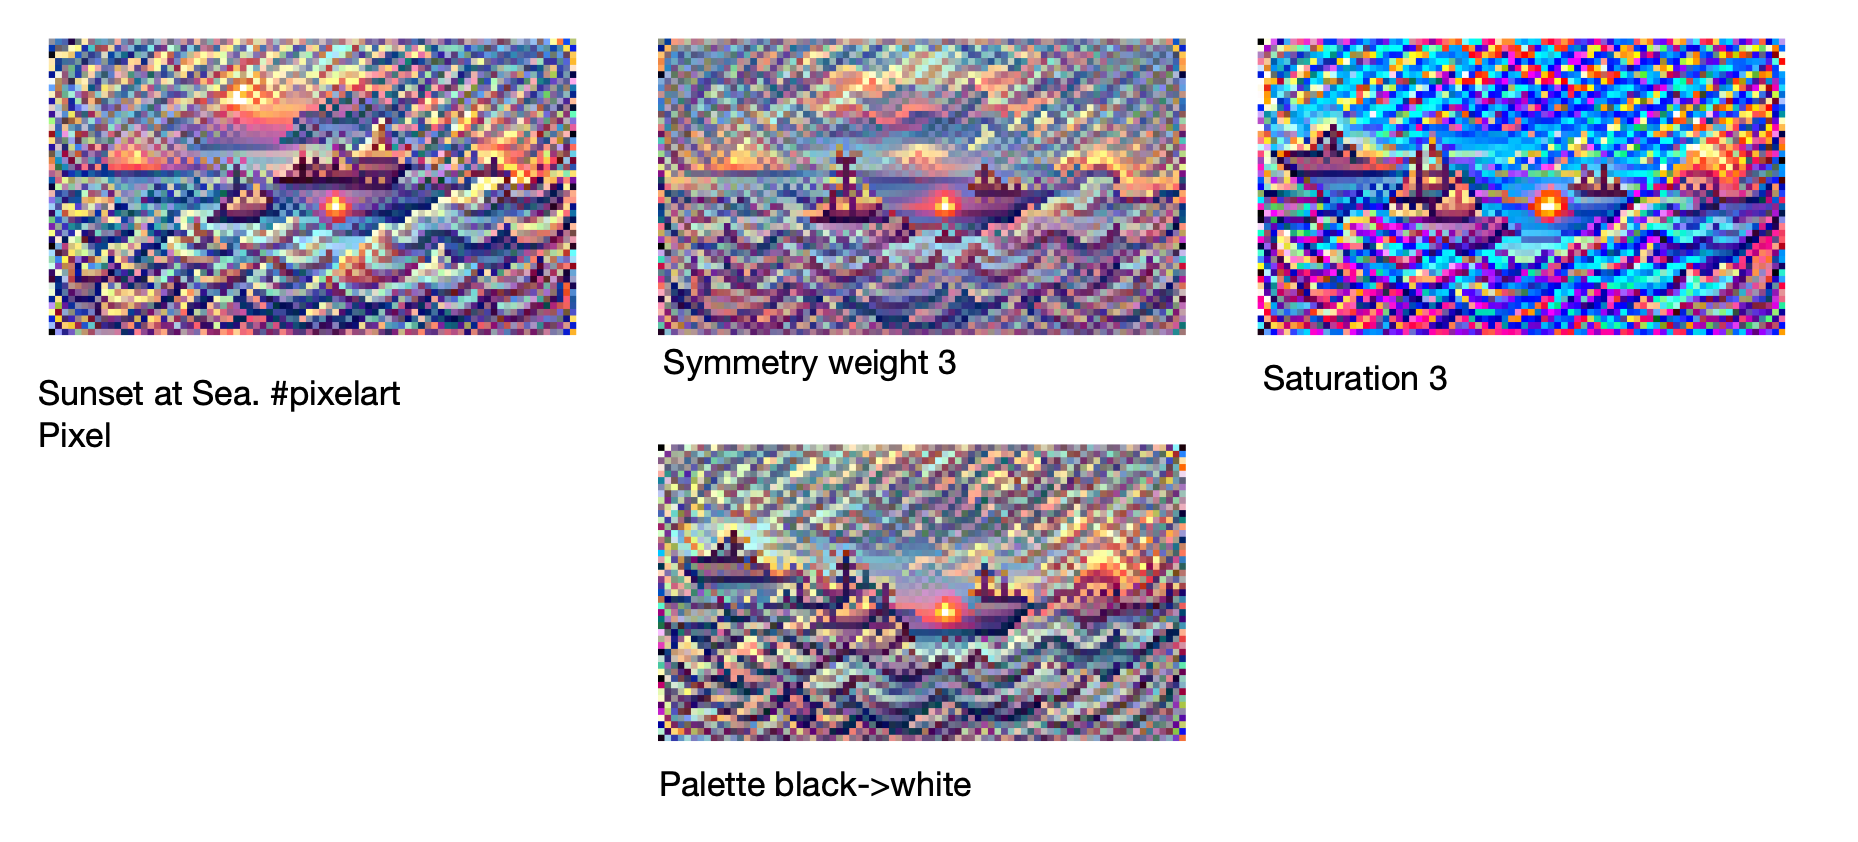

In [ ]:
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left. For setup,
#@markdown **you need to run this cell,
#@markdown then choose Runtime -> Restart Runtime from the menu,
#@markdown and then run the cell again**. It should remind you to
#@markdown do this after the first run.

#@markdown Setup can take 5-10 minutes, but once it is complete it usually does not need to be repeated
#@markdown until you close the window.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

# https://stackoverflow.com/a/56727659/1010653

# Add a gpu check
# (this can get better over time)
from google.colab import output

nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  warning_string = f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, THIS IS PROBABLY NOT ENOUGH <--"
  print(warning_string)
  output.eval_js('alert("Warning - low GPU (see message)")')
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

from IPython.utils import io
with io.capture_output() as captured:
  # On 2021/10/08, Colab updated its default PyTorch installation to a version that causes
  # problems with diffvg. So, first thing, let's roll back to the older version:
  !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torch-optimizer==0.1.0 -f https://download.pytorch.org/whl/torch/ -f https://download.pytorch.org/whl/torchvision/

  !git clone https://github.com/openai/CLIP
  # !pip install taming-transformers
  !git clone https://github.com/CompVis/taming-transformers.git
  !rm -Rf pixray
  !git clone -b customloss https://github.com/DazhiZhong/pixray
  !pip install ftfy regex tqdm omegaconf pytorch-lightning
  !pip install kornia
  !pip install imageio-ffmpeg   
  !pip install einops
  !pip install torch-optimizer==0.1.0
  !pip install easydict
  !pip install braceexpand
  !pip install git+https://github.com/pvigier/perlin-numpy

  # ClipDraw deps
  !pip install svgwrite
  !pip install svgpathtools
  !pip install cssutils
  !pip install numba
  !pip install torch-tools
  !pip install visdom

  !git clone https://github.com/BachiLi/diffvg
  %cd diffvg
  # !ls
  !git submodule update --init --recursive
  !python setup.py install
  %cd ..

output.clear()
import sys
sys.path.append("pixray")

result_msg = "setup complete"
import IPython
import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  result_msg = "Please choose Runtime -> Restart Runtime from the menu, and then run Setup again"

js_code = f'''
document.querySelector("#output-area").appendChild(document.createTextNode("{result_msg}"));
'''
js_code += '''
for (rule of document.styleSheets[0].cssRules){
  if (rule.selectorText=='body') break
}
rule.style.fontSize = '30px'
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [ ]:
#@title adding a custom loss class `GlobalColorLoss`
import torch
from torch import nn
from Losses.LossInterface import LossInterface

class GlobalColorLoss(LossInterface):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    
    @staticmethod
    def add_settings(parser):
        parser.add_argument("-gcol",  "--global_color", nargs=3, type=float, help="enforce a global color average", default=[255,255,255], dest='global_color')
        parser.add_argument("-gcolw",  "--global_color_weight", type=float, help="global color average weight", default=0.5, dest='global_color_weight')
        return parser

    
    def forward(self, cur_cutouts, out, args, globals=None, lossGlobals=None):
        cur_loss = 0
        col = torch.tensor(args.global_color).to(self.device)/255
        mean_col = torch.mean(out,axis=[0,2,3])
        # print(mean_col)
        # print(col)
        mseloss = nn.MSELoss()
        cur_loss = mseloss(mean_col, col) 
        return cur_loss*args.global_color_weight


In [ ]:
#@title Selecting settings

#@markdown Enter a description of what you want to draw - I usually add #pixelart to the prompt.
#@markdown The renderer can also be swapped with other models such
#@markdown as VQGAN or CLIPDraw. <br>

prompts = "Sunset at Sea. #pixelart" #@param {type:"string"}

aspect = "widescreen" #@param ["widescreen", "square"]

drawer = "pixel" #@param ["vqgan", "pixel", "line_sketch", "clipdraw"]

seed = 16527453269420328448 #@param{type:"number"}

iterations = 100 #@param{type:"number"}

#@markdown ###custom losses

#@markdown saturation loss config: saturation loss measures
#@markdown the
saturation = False #@param {type:"boolean"}
saturation_weight =  3#@param {type:"number"}

#@markdown smoothness loss config
smoothness = False #@param {type:"boolean"}
smoothness_weight =  3#@param {type:"number"}
smoothness_type = "default" #@param ["default","clipped","log"]

#@markdown palette loss config
palette = True #@param {type:"boolean"}
enforce_palette_annealing = 10000 #@param {type:"number"}
target_palette = "black->white" #@param {type:"string"}

#@markdown symmetry loss config
symmetry = False #@param {type:"boolean"}
symmetry_weight =  0.2#@param {type:"number"}

#@markdown global color loss config
use_global_color = False #@param {type:"boolean"}
global_color = [36,51,110] #@param
global_color_weight = 0.2 #@param {type:"number"}

#@markdown When you have the settings you want, press the play button on the left.
#@markdown The system will save these and start generating images below.

#@markdown When that is done you can change these
#@markdown settings and see if you get different results. Or if you get
#@markdown impatient, just select "Runtime -> Interrupt Execution".
#@markdown Note that the first time you run it may take a bit longer
#@markdown as nessary files are downloaded.

/usr/local/lib/python3.7/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


Using seed: 16527453269420328448
Running pixeldrawer with 80x45 grid
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Sunset at Sea. #pixelart']
using custom losses: ['palette']


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


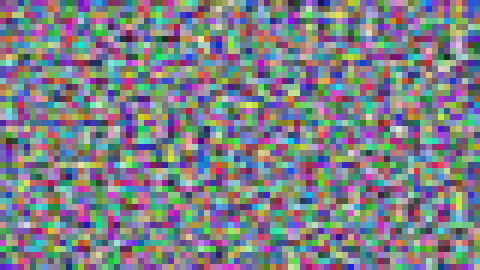

iter: 0, loss: 2.95, losses: 0.977, 0.0798, 0.893, 0.047, 0.904, 0.0486,  0 (-0=>2.949)
iter: 10, loss: 2.75, losses: 0.927, 0.0791, 0.819, 0.0446, 0.833, 0.0466, 0.00604 (-1=>2.754)


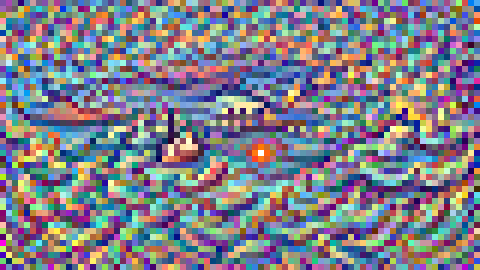

iter: 20, loss: 2.52, losses: 0.873, 0.0791, 0.734, 0.0462, 0.727, 0.0494, 0.0129 (-2=>2.5)
iter: 30, loss: 2.44, losses: 0.839, 0.0808, 0.702, 0.0489, 0.702, 0.0501, 0.0196 (-2=>2.378)


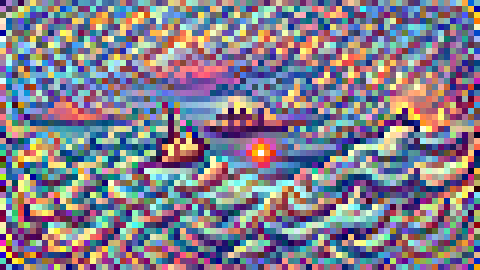

iter: 40, loss: 2.31, losses: 0.793, 0.0818, 0.662, 0.0517, 0.648, 0.0508, 0.0265 (-0=>2.314)
iter: 50, loss: 2.32, losses: 0.793, 0.0827, 0.66, 0.0524, 0.652, 0.0511, 0.031 (-10=>2.314)


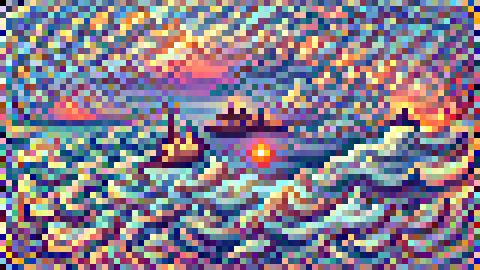

iter: 60, loss: 2.37, losses: 0.808, 0.0826, 0.672, 0.051, 0.667, 0.0506, 0.0365 (-2=>2.298)
iter: 70, loss: 2.33, losses: 0.793, 0.0831, 0.657, 0.051, 0.655, 0.0509, 0.0409 (-8=>2.266)
Dropping learning rate


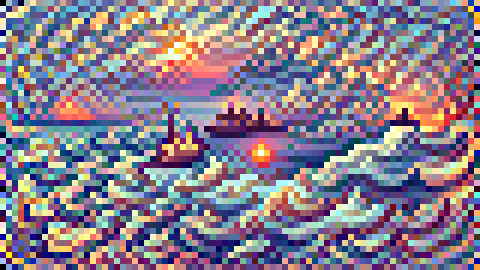

iter: 80, loss: 2.24, losses: 0.761, 0.0824, 0.631, 0.0535, 0.618, 0.0528, 0.0453 (-0=>2.244)
iter: 90, loss: 2.29, losses: 0.771, 0.0836, 0.642, 0.0528, 0.635, 0.0519, 0.0498 (-10=>2.244)


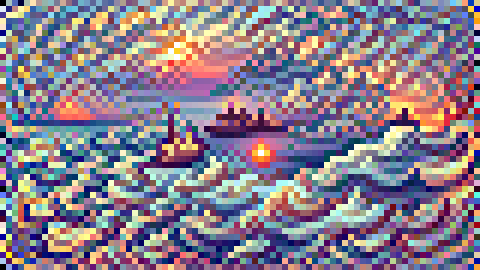

iter: 100, finished (-20=>2.244)


True

In [ ]:
#@title Simple setup and run
import pixray

# these are good settings for pixeldraw
pixray.reset_settings()
pixray.add_settings(prompts=prompts, aspect=aspect)
pixray.add_settings(quality="better", scale=2.5)
pixray.add_settings(drawer=drawer)
pixray.add_settings(display_clear=False)
pixray.add_settings(seed=seed)
pixray.add_settings(noise_prompt_seeds=[34512312367865,4987656788765,123123123655])
pixray.add_settings(iterations=iterations)

# by default we'll turn on textoff
pixray.add_settings(vector_prompts="textoff")

# adding from colab
pixray.add_custom_loss("global_color",GlobalColorLoss)

# add losses to settings
enabled = {
    "palette": palette,
    "saturation": saturation,
    "symmetry": symmetry,
    "smoothness": smoothness,
    "global_color": use_global_color
}
enabled = [i for i in filter(lambda x: enabled[x],enabled.keys())]
pixray.add_settings(custom_loss=enabled)

# loss configs
if saturation:
    pixray.add_settings(saturation = saturation_weight)
if smoothness:
    pixray.add_settings(smoothness=smoothness_weight)
    pixray.add_settings(smoothness_type=smoothness_type)
if palette:
    pixray.add_settings(enforce_palette_annealing=enforce_palette_annealing)
    pixray.add_settings(target_palette=target_palette)
if symmetry:
    pixray.add_settings(symmetry_weight=symmetry_weight)
if use_global_color:
    pixray.add_settings(global_color=global_color)
    pixray.add_settings(global_color_weight=global_color_weight)

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)
